# Find patterns by site in heatmap
In this notebook the following tasks will be accomplished:

1. Create arrays for heatmap, one per meter-site.
2. Find patterns in those arrays. Here are looked for two kind of patterns:
    - Dates when the number of buildings over `tresh_bdg`, have an error over `tresh_error`. This would be an atypical date in that site.
    - Buildings that have consecutive dates with high error during a period longer than `tresh_dates`. This would be an atypical behaviour in that building.

In [1]:
import sys
sys.path.append("..\\source\\")
import utils as utils
import glob

# Data and numbers
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
path_data = "..\\data\\processed\\summary\\"
path_leak = "..\\data\\leaked\\"
path_meta = "..\\data\\original\\metadata\\"
path_arrays = "..\\data\\processed\\arrays\\"
path_res = "..\\results\\"

In [5]:
def heatmapComp(df,df_bool):

    """This function plots two heatmaps side by side:
        - The original heatmap\n
        - A heatmap where only values over ´tresh_error´ are colored\n

        df: original values for a meter-site.
        df_bool: masked df for that meter-site, where only values over `tresh_error` are 1 (otherwise, 0)\n
    """
    
    fig, axes = plt.subplots(1, 2, sharex = True, sharey=True, figsize=(16,8))
    axes = axes.flatten()

    # Get the data
    y = np.linspace(0, len(df), len(df)+1)
    x = pd.date_range(start='2017-01-01', end='2018-12-31')
    cmap = plt.get_cmap('YlOrRd')

    for i,data in enumerate([df_bool,df]):
        
        # Plot
        ax = axes[i]
        data = data
        qmesh = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=True, vmin=0, vmax=1)

        # Axis
        plt.locator_params(axis='y', nbins=len(list(data.index)) + 1)
        ax.axis('tight') 
        ax.xaxis_date() # Set up as dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # set date's format
        ax.set_yticklabels(list(df_bool.index)) # omit building ID on y axis

    # Color bar  
    cbar = fig.colorbar(qmesh, ax=ax)
    cbar.set_label('Min-Max scaled RMSLE')

    fig.suptitle(f"{meter} - site {site}", y = 1.015, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)
    plt.pcolormesh(df, cmap='YlOrRd', rasterized=True)

    return fig

## Create arrays for heatmap

In [49]:
"""meters = ["electricity","chilledwater","hotwater","steam"]
group = "site_id"
metric = "RMSLE"

for meter in meters:

    # Load data
    df = pd.read_pickle(path_data + f"date_vs_bdg\\{meter}_RMSLE.pickle.gz")

    # Remove leaked buidings
    leak = pd.read_csv(path_leak + f"leak_{meter}.csv")
    df = df[df.building_id.isin(leak.building_id) == False]

    # Datetime object
    df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d")

    # Complete missing dates
    df = utils.completeData(df,"2017-01-01","2018-12-31")

    # Merge with metadata
    meta_bdg = pd.read_csv(path_meta + "building_metadata.csv")
    df = pd.merge(df, meta_bdg, how="left", on="building_id")

    # Scale metric between 0 and 1
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_rmsle = scaler.fit_transform(np.array(df.rmsle).reshape(-1, 1))
    # Add to df
    df["rmsle_scaled"] = scaled_rmsle
    # Print limits
    print(f"Meter: {meter}")
    print(f"Min rmsle: {df.rmsle.min()}. Max rmsle: {df.rmsle.max()}")
    print(f"Min rmsle_scaled: {df.rmsle_scaled.min()}. Max rmsle_scaled: {df.rmsle_scaled.max()}")
    print("")

    # Create arrays
    group_name = list(df[group].unique())

    for i,j in enumerate(group_name):

        # Filter data
        df_grouped = df[df[group] == j]

        # Pivot data
        pivot_df = df_grouped.pivot(columns="timestamp", index="building_id", values="rmsle_scaled")

        # Sort in descending order (sum RMSLE)
        pivot_df["sum"] = np.sum(pivot_df,axis=1).tolist()
        pivot_df = pivot_df.sort_values("sum")
        pivot_df.drop("sum",axis=1, inplace=True)

        # Save df
        pivot_df.to_csv(path_arrays + f"{meter}_{metric}_site_{j}.csv")
        """

Meter: electricity
Min rmsle: 0.03999936208128929. Max rmsle: 8.138672828674316
Min rmsle_scaled: 0.0. Max rmsle_scaled: 1.0

Meter: chilledwater
Min rmsle: 0.07142580300569534. Max rmsle: 8.397016525268555
Min rmsle_scaled: 0.0. Max rmsle_scaled: 1.0

Meter: hotwater
Min rmsle: 0.11213328689336777. Max rmsle: 8.06053352355957
Min rmsle_scaled: 0.0. Max rmsle_scaled: 1.0

Meter: steam
Min rmsle: 0.0737953633069992. Max rmsle: 9.318635940551758
Min rmsle_scaled: 0.0. Max rmsle_scaled: 1.0



## Find patterns

### Dates and building patterns

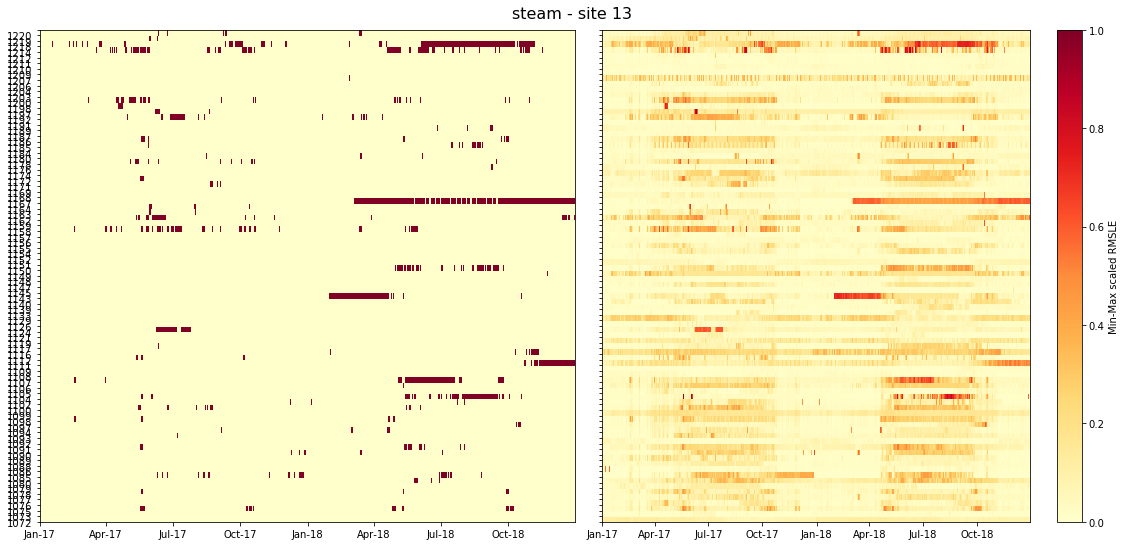

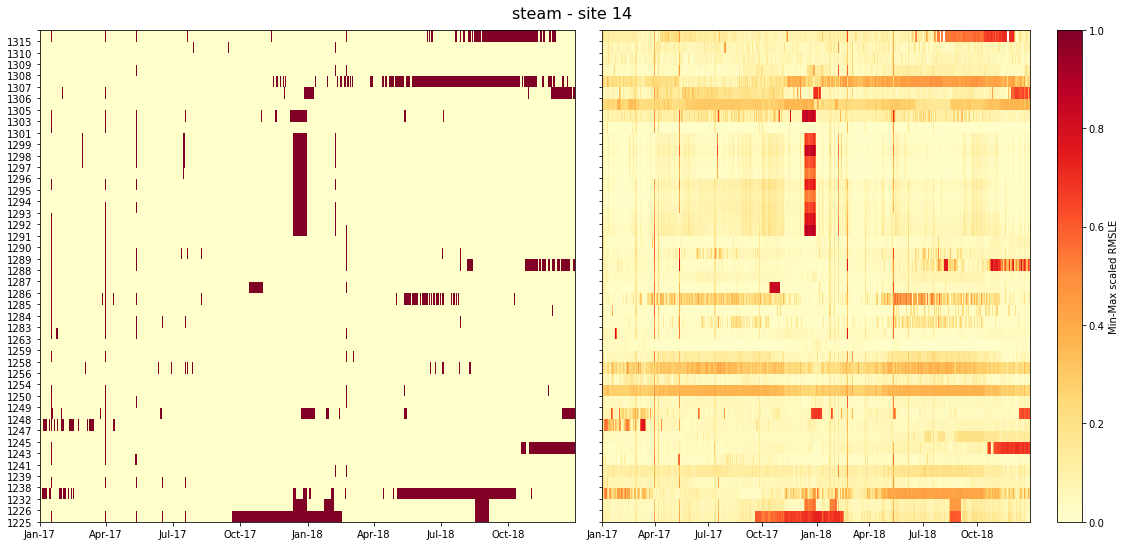

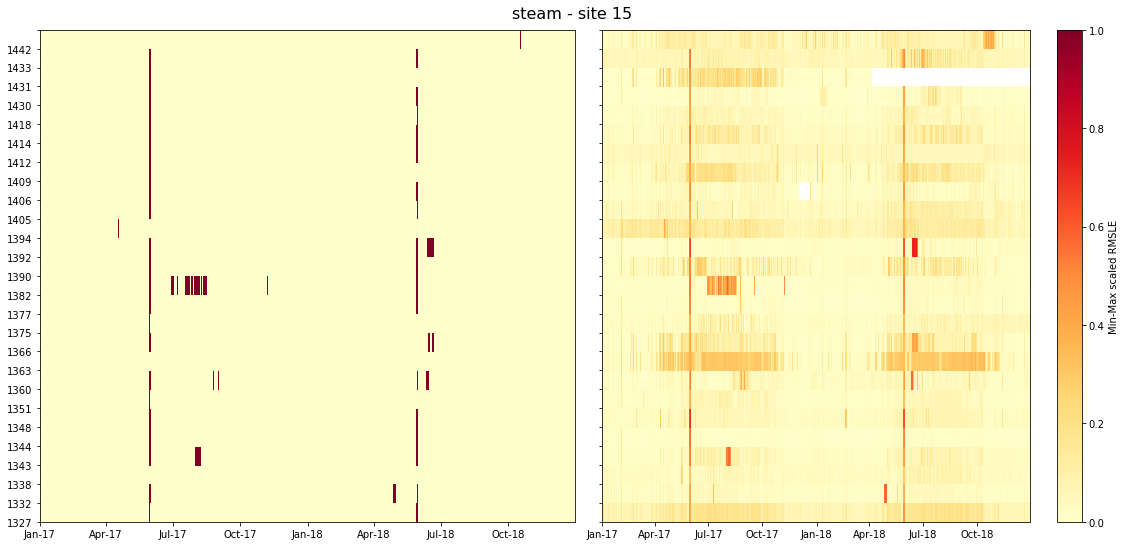

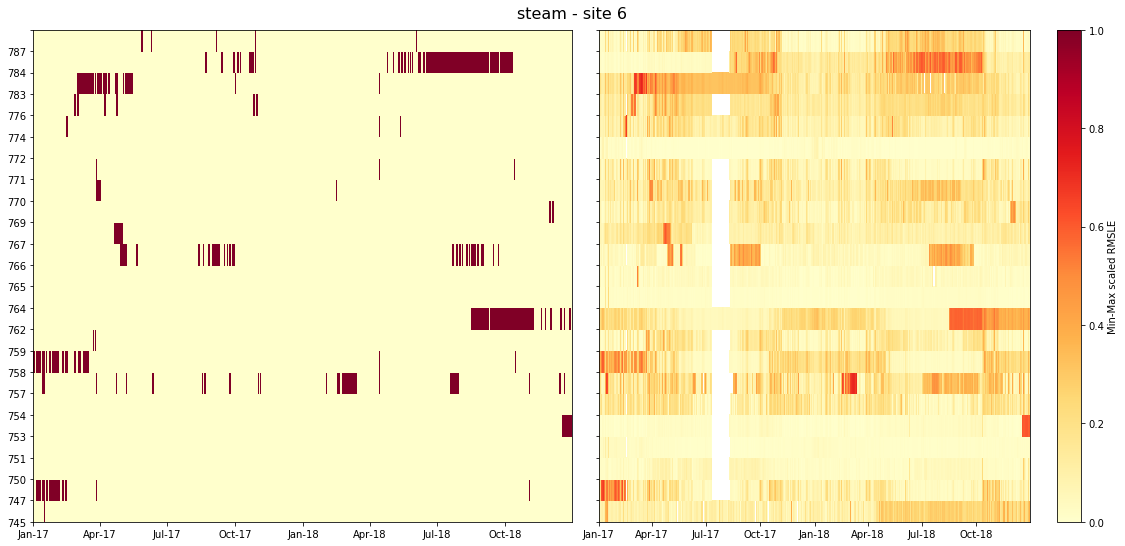

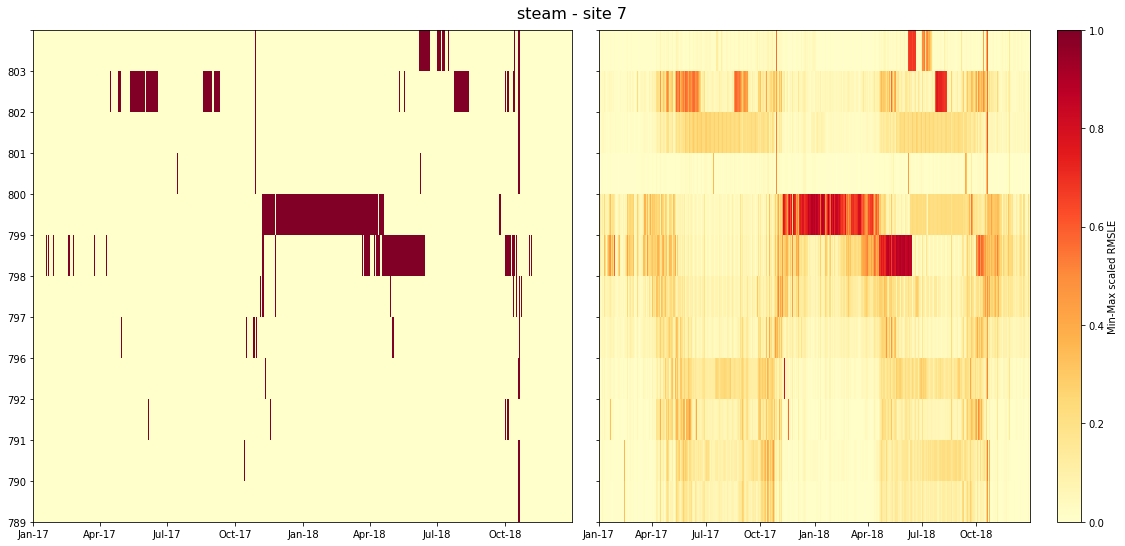

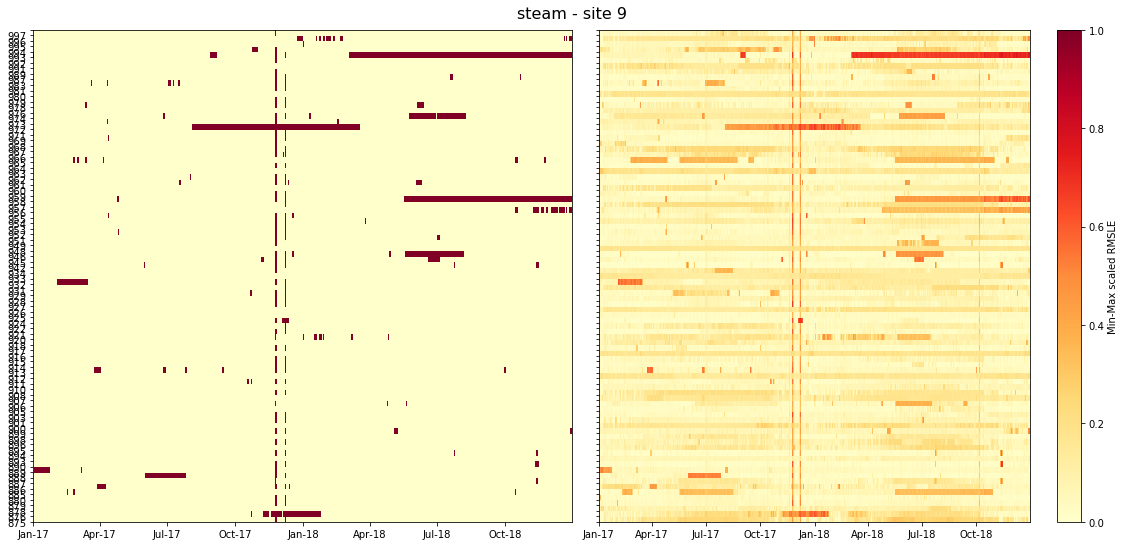

In [4]:
meter = "steam"
files = glob.glob(path_arrays + f"{meter}*.csv")
tresh_error = 0.4
tresh_bdg = 0.33
tresh_dates = 3

for file in files:
    # Site id
    site = file.split("\\")[-1].split("_")[-1].split(".")[0]

    # Load data
    df = pd.read_csv(file).set_index("building_id")
    # Color only error greater than treshold
    df_bool = (df > tresh_error).astype(int)

    # Compare figures
    fig = heatmapComp(df,df_bool)
    fig.savefig(path_res + f"{meter}_site_{site}_comp.png", bbox_inches='tight', dpi=200)

    ### GET HIGH ERRORS BY DATE ###
    # Sum values for each date
    by_date = pd.DataFrame(df_bool.sum()).reset_index().rename(columns={"index":"date",0:"sum_val"})
    # Filter dates that has high error in more than 33% of buildings
    results = by_date[by_date.sum_val > tresh_bdg*len(df_bool.index)]
    results.to_csv(path_res + f"{meter}_site_{site}_dates.csv", index=False)

    ### GET HIGH ERRORS BY BDG ###
    dfs = []
    df_bdg = df_bool.T

    for col in df_bdg.columns:
        # Select one building
        df = df_bdg[[col]]
        # Tag groups of consequtive equal numbers
        df['grp'] = (df[col] != df[col].shift()).cumsum()
        # Filter values == 1 (error higher than treshold)
        df = df.loc[df[col] == 1,].reset_index().rename(columns={"index":"date"}, index={"building_id":"index"})[["date","grp"]]
        # Add bdg number
        df["building_id"] = col
        # Get buildings with high error during period longer than tresh_dates
        by_group = df[["date","grp"]].groupby("grp").count().reset_index() # group
        groups = list(by_group.loc[by_group.date > tresh_dates, "grp"]) # get list of groups
        df = df[df.grp.isin(groups) == True] # filter and get only those groups

        # Append to list
        dfs.append(df)

    # Concat all
    df = pd.concat(dfs)
    df.to_csv(path_res + f"{meter}_site_{site}_bdg.csv", index=False)

### Gradual patterns

In [19]:
meter = "steam"
files = glob.glob(path_arrays + f"{meter}*.csv")
tresh_error = 0.3
tresh_dates = 3
tresh_pct = 0.05

In [20]:
for file in files:

    # Site id
    site = file.split("\\")[-1].split("_")[-1].split(".")[0]

    # Load data
    df = pd.read_csv(file).set_index("building_id")

    #### MARK GRADUAL ERRORS ####

    dfs = [] # empty list to save results
    dfT = df.T # transpose df

    for col in dfT.columns:
        # Filters only one bdg
        temp = dfT[[col]]
        # Calculate change between consecutive rows
        temp["change"] = temp[col].pct_change(periods=1, fill_method='pad', limit=None, freq=None)
        # Mark rows over error threshold AND over change threshold
        temp["mark"] = [1 if ((abs(x) >= tresh_pct) & (y >= tresh_error)) else 0 for x,y in zip(temp.change,temp[col])]
        #append to list
        dfs.append(temp[["mark"]].rename(columns={"mark":col}))
    # Concat results
    df_grad = pd.concat(dfs,axis=1) 

    dates = pd.DataFrame({"date":df.columns})

    #### MARK GRADUAL ERRORS LONGER THAN DATES THRESHOLD ####

    dfs = [] #empty list to save results

    for col in df_grad.columns:
        # Select one building
        df1 = df_grad[[col]]
        # Tag groups of consecutive equal numbers
        df1['grp'] = (df1[col] != df1[col].shift()).cumsum()
        # Filter values == 1 (error and difference higher than treshold)
        df1 = df1.loc[df1[col] == 1,].reset_index().rename(columns={"index":"date"}, index={"building_id":"index"})[["date","grp"]]
        # Get buildings with high error during period longer than tresh_dates
        by_group = df1[["date","grp"]].groupby("grp").count().reset_index() # group
        groups = list(by_group.loc[by_group.date > tresh_dates, "grp"]) # get list of groups
        df1 = df1[df1.grp.isin(groups) == True] # filter and get only those groups
        # Add building ID
        df1["building_id"] = col

        """# Merge with whole dates
        df1 = pd.merge(dates,df1,how="left",on="date")
        # Add building ID
        df1["building_id"] = col"""

        # Append to list
        dfs.append(df1)

    # Concat all
    df_grad = pd.concat(dfs)
    # Export file
    df_grad.to_csv(path_res + f"{meter}_site_{site}_grad.csv", index=False)

## Concat dfs

In [21]:
meters = ["chilledwater","hotwater","electricity","steam"]
groups = ["bdg","dates","grad"]

for meter in meters:

    for group in groups:

        print(f"{meter} - {group}")

        # Files for each meter-group
        files = glob.glob(path_res + f"{meter}_*_{group}.csv")
        print(f"Files: {len(files)}")
        # Empty list to save dfs
        dfs = []

        for file in files:
            # Site ID
            site = file.split("\\")[-1].split(".")[0].split("_")[2]
            print(f"Site ID: {site}")
            # Load data
            df = pd.read_csv(file)
            df["site_id"] = site
            # Append to list
            dfs.append(df)

        # Concat all
        df = pd.concat(dfs)
        # Export file
        df.to_csv(path_res + f"{meter}_{group}.csv", index=False)

chilledwater - grad
Files: 9
Site ID: 10
Site ID: 11
Site ID: 13
Site ID: 14
Site ID: 15
Site ID: 2
Site ID: 6
Site ID: 7
Site ID: 9
hotwater - grad
Files: 6
Site ID: 10
Site ID: 11
Site ID: 14
Site ID: 15
Site ID: 1
Site ID: 7
electricity - grad
Files: 15
Site ID: 10
Site ID: 11
Site ID: 12
Site ID: 13
Site ID: 14
Site ID: 15
Site ID: 1
Site ID: 2
Site ID: 3
Site ID: 4
Site ID: 5
Site ID: 6
Site ID: 7
Site ID: 8
Site ID: 9
steam - grad
Files: 6
Site ID: 13
Site ID: 14
Site ID: 15
Site ID: 6
Site ID: 7
Site ID: 9
